In [21]:
# Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf

# Parameters 
n = 3 #the # of article headlines displayed per ticker
tickers = ['AAPL', 'TSLA', 'GOOG','WMT', 'CMG', 'XOM']

In [2]:
# Scrape Data from FinViz using BeautifulSoup
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {} #create empty dictionary

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) #request data from the URL #header allows us to have access
    response = urlopen(req)    #beautiful soup can take this in and parse data out of
    html = BeautifulSoup(response, features="lxml") #pass the response through Beautiful Soup
    news_table = html.find(id='news-table') #all articles are located in a table- see id in HTML code from website
    news_tables[ticker] = news_table #ticker is the key to the dictionary 

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass



Recent News Headlines for AAPL: 
Encrypted chat app Signal reveals flaws in Cellebrite equipment ( Apr-21-21 04:28PM )
Why analysts are bullish on Apple stock ( 04:09PM )
Apples iPad Pro is making its own laptops obsolete ( 03:55PM )


Recent News Headlines for TSLA: 
ARK Invest Stocks To Buy And Watch: 6 Stocks That Cathie Wood's ARK ETFs Own; Tesla Races Higher ( Apr-21-21 04:01PM )
Is GM Stock A Buy? General Motors Delivers Self-Driving, EV Surprises ( 03:36PM )
Dow Rallies 200 Points As Netflix Plunges On Earnings; Apple, Tesla Reverse Higher ( 01:34PM )


Recent News Headlines for GOOG: 
Small businesses 'had to become digital' amid COVID-19: Facebook VP ( Apr-21-21 04:25PM )
Why analysts are bullish on Apple stock ( 04:09PM )
Daily Mail publisher accuses Google of manipulating search results and rigging online ad auctions ( 04:00PM )


Recent News Headlines for WMT: 
Small businesses 'had to become digital' amid COVID-19: Facebook VP ( Apr-21-21 04:25PM )
4 Dow Jones Stocks To 

In [3]:
# Format the Data for Sentiment Analysis by iterating through collected news and sorting into list with tickers, dates, times, and headlines
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1: #implies that we only have timestamp
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])
    
print(parsed_news)

[['AAPL', 'Apr-21-21', '04:28PM', 'Encrypted chat app Signal reveals flaws in Cellebrite equipment'], ['AAPL', 'Apr-21-21', '04:09PM', 'Why analysts are bullish on Apple stock'], ['AAPL', 'Apr-21-21', '03:55PM', 'Apples iPad Pro is making its own laptops obsolete'], ['AAPL', 'Apr-21-21', '03:51PM', 'Spotify, Match Tell Senate Apple Is Abusing Power in App Store'], ['AAPL', 'Apr-21-21', '03:45PM', 'Senate hearing on app stores puts Apple, Google under regulatory spotlight'], ['AAPL', 'Apr-21-21', '02:21PM', "UPDATE 1-Facebook tweaks ad tools ahead of Apple's privacy changes"], ['AAPL', 'Apr-21-21', '02:17PM', 'FTC Nominee Khan Calls for More Scrutiny of Tech Giants Power'], ['AAPL', 'Apr-21-21', '02:03PM', 'UPDATE 1-Epic CEO, Apple App Store chief to attend antitrust trial starting May 3'], ['AAPL', 'Apr-21-21', '01:39PM', 'Dow Jones Rallies 230 Points As Stock Market Rebounds, But Netflix Gets Slammed'], ['AAPL', 'Apr-21-21', '01:36PM', '4 Dow Jones Stocks To Buy And Watch In April 202

In [4]:
# Sentiment Analysis with NLTK VADER Sentiment
vader = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns) #create dataframe to host data

f = lambda Headline: vader.polarity_scores(Headline)['compound']
news['compound'] = news['Headline'].apply(f)
#scores = news['Headline'].apply(vader.polarity_scores).tolist()
news.head()
# df_scores = pd.DataFrame(scores)
# news = news.join(df_scores, rsuffix='_right')
# news.head()


,Ticker,Date,Time,Headline,compound
0,AAPL,Apr-21-21,04:28PM,Encrypted chat app Signal reveals flaws in Cel...,0.0000
1,AAPL,Apr-21-21,04:09PM,Why analysts are bullish on Apple stock,0.0000
2,AAPL,Apr-21-21,03:55PM,Apples iPad Pro is making its own laptops obso...,-0.2960
3,AAPL,Apr-21-21,03:51PM,"Spotify, Match Tell Senate Apple Is Abusing Po...",-0.4588
4,AAPL,Apr-21-21,03:45PM,"Senate hearing on app stores puts Apple, Googl...",0.0000


<Figure size 1800x720 with 0 Axes>

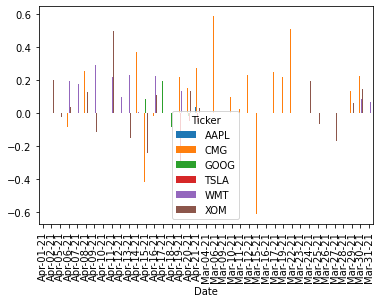

<Figure size 1800x720 with 0 Axes>

In [49]:
#Manipulate the Data in order to create a plot
mean_news= news.groupby(['Ticker', 'Date']).mean() 
mean_news = mean_news.unstack() #need the date as x axis
mean_news = mean_news.xs('compound', axis= 'columns').transpose() 
mean_news.plot(kind='bar')
plt.figure(figsize=(25,10))

In [6]:
#testing VADER
print(vader.polarity_scores('Apple is the worst company ever'))

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}


In [7]:
#testing VADER
print(vader.polarity_scores('Apple is a bad company and will fail'))

{'neg': 0.583, 'neu': 0.417, 'pos': 0.0, 'compound': -0.7906}


In [8]:
#testing VADER
print(vader.polarity_scores('Apple is a great company and will fail'))

{'neg': 0.278, 'neu': 0.397, 'pos': 0.325, 'compound': 0.1531}


In [53]:
#RNN LSTM MODEL

# Pre-Processing for RNN input
# Create Feature and Label sets
# Creating the X and y vectors
X = news["Headline"].values
y = news["compound"].values

In [24]:
# Import Keras modules for data encoding #encode data as integer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
# Create an instance of the Tokenizer and fit it with the X text data
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

In [26]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:5]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

word: 'to', token: 1
word: 'in', token: 2
word: 'and', token: 3
word: 'apple', token: 4
word: 'the', token: 5


In [27]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

# Contrast a sample numerical sequence with its text version
print("**Text comment**")
print({X[0]})
print("**Numerical sequence representation**")
print(X_seq[0])

**Text comment**
{'Encrypted chat app Signal reveals flaws in Cellebrite equipment'}
**Numerical sequence representation**
[878, 879, 95, 384, 292, 880, 2, 881, 882]


In [28]:
# Padding sequences
X_pad = pad_sequences(X_seq, maxlen=140, padding="post")

In [29]:
X_pad

array([[ 878,  879,   95, ...,    0,    0,    0],
       [  50,  549,   43, ...,    0,    0,    0],
       [ 195,   51,  115, ...,    0,    0,    0],
       ...,
       [ 174,  330, 1919, ...,    0,    0,    0],
       [  31,  134,  291, ...,    0,    0,    0],
       [ 870,  871,   79, ...,    0,    0,    0]], dtype=int32)

In [30]:
# Creating training, validation, and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, random_state=78)

In [31]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [32]:
# Model set-up
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
max_words = 140
embedding_size = 64

In [33]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=280))

# Output layer
model.add(Dense(1, activation="sigmoid"))

In [80]:
# # Compile the model
# model.compile(
#     loss="binary_crossentropy",
#     optimizer="adam"
# )
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [81]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 64)           123008    
_________________________________________________________________
lstm (LSTM)                  (None, 280)               386400    
_________________________________________________________________
dense (Dense)                (None, 1)                 281       
Total params: 509,689
Trainable params: 509,689
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Training the model
batch_size = 1000
model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.1553
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 0.1614
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 0.1620
Epoch 4/30
1/1 [==============================] - 1s 1s/step - loss: 0.1585
Epoch 5/30
1/1 [==============================] - 1s 1s/step - loss: 0.1549
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: 0.1530
Epoch 7/30
1/1 [==============================] - 1s 1s/step - loss: 0.1528
Epoch 8/30
1/1 [==============================] - 1s 1s/step - loss: 0.1534
Epoch 9/30
1/1 [==============================] - 1s 1s/step - loss: 0.1542
Epoch 10/30
1/1 [==============================] - 1s 1s/step - loss: 0.1547
Epoch 11/30
1/1 [==============================] - 1s 1s/step - loss: 0.1548
Epoch 12/30
1/1 [==============================] - 1s 1s/step - loss: 0.1546
Epoch 13/30
1/1 [==============================] - 1s 1s/step - loss: 0.1541
Epoch 14

In [85]:
#evaluate the model
model.evaluate(X_test, y_test)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

5/5 [==============================] - 3s 65ms/step - loss: 0.2814 - accuracy: 0.4124 - tp: 0.0000e+00 - tn: 42.1667 - fp: 0.0000e+00 - fn: 61.1667 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000


NameError: name 'score' is not defined

In [84]:
# Accuracy
from sklearn.metrics import accuracy_score

print("RNN LSTM Accuracy %.2f" % (accuracy_score(X_test, y_test)))

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and continuous targets

In [73]:
# Make sentiment predictions #predict using testing data and model
predicted = (model.predict(X_test[:10])>0.5).astype("int32")

In [74]:
#compares the actual text from original dataframe to the predicted values
_, X_test_original, _, _ = train_test_split(X, y, random_state=42)

In [69]:
# Create a DataFrame of Real and Predicted values
sentiments = pd.DataFrame({"Text": X_test_original[:10], "Actual": y_test[:10], "Predicted": predicted2.ravel()})
sentiments

,Text,Actual,Predicted
0,Tesla comes under growing China pressure after...,0.1779,0
1,"Wendy's CEO: We are on our way to 8,000 restau...",0.0000,0
2,ExxonMobil (XOM) to Conduct Testing of Lower-C...,0.4854,0
3,"Apple Introduces Apple Card Family, Enabling P...",-0.6124,0
4,How Investors Maxed Out Gains From This Record...,0.0000,0
5,Google Pledges More Than $2.5M For COVID-19 Va...,0.0000,0
6,Dow Rallies 200 Points As Netflix Plunges On E...,0.0000,0
7,Jack in the Box CEO on the companys best quart...,0.0000,0
8,UPDATE 3-Apple announces AirTags for lost item...,0.0000,0
9,"Walmart China, Dada Group's JDDJ Extend Omni-C...",0.0000,0


<AxesSubplot:>

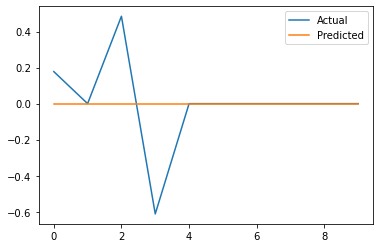

In [76]:
sentiments.plot()

In [ ]:
#